In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import networkx as nx
import random
import pickle
import itertools
import urllib.request as urllib
import io
import zipfile

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.linalg import diag
from func_timeout import func_timeout, FunctionTimedOut
from tensorflow.keras import callbacks
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from networkx.generators.community import LFR_benchmark_graph
from itertools import count

from helpers import *
from Autoencoder import *

In [2]:
#KARATE CLUB
kc = nx.karate_club_graph()

X_kc_1 = tf.convert_to_tensor(nx.modularity_matrix(kc))

ae_kc_1 = Autoencoder(34, 32)
ae_kc_1.compile(optimizer='adam', loss="mse")
ae_kc_1.fit(X_kc_1, X_kc_1, epochs=5000, shuffle=True, batch_size=34, verbose=0)

pickle.dump(kc, open("kc.p", "wb"))
ae_kc_1.save("ae_kc_1")

M_kc_1 = ae_kc_1.predict(X_kc_1)
H_kc_1 = ae_kc_1.encoder(X_kc_1)
X_kc_2 = H_kc_1

ae_kc_2 = Autoencoder(32, 16)
ae_kc_2.compile(optimizer='adam', loss="mse")
ae_kc_2.fit(X_kc_2, X_kc_2, epochs=5000, shuffle=True, batch_size=32, verbose=0)

ae_kc_2.save("ae_kc_2")

INFO:tensorflow:Assets written to: ae_kc_1\assets
INFO:tensorflow:Assets written to: ae_kc_2\assets


In [3]:
H_kc_2 = ae_kc_2.encoder(H_kc_1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(H_kc_2)
labels = karate_club_communities(kc)

In [4]:
normalized_mutual_info_score(labels, kmeans.labels_)

0.8371694628777809

In [8]:
#LFR

lfr = pickle.load(open("lfr.p", "rb"))

In [9]:
X_lfr_1 = tf.convert_to_tensor(nx.modularity_matrix(lfr))

ae_lfr_1 = Autoencoder(1000, 512)
ae_lfr_1.compile(optimizer='adam', loss="mse")
ae_lfr_1.fit(X_lfr_1, X_lfr_1, epochs=5000, shuffle=True, batch_size=1000, verbose=0)

X_lfr_2 = ae_lfr_1.encoder(X_lfr_1)

ae_lfr_2 = Autoencoder(512, 256)
ae_lfr_2.compile(optimizer='adam', loss="mse")
ae_lfr_2.fit(X_lfr_2, X_lfr_2, epochs=5000, shuffle=True, batch_size=1000, verbose=0)

X_lfr_3 = ae_lfr_2.encoder(X_lfr_2)

ae_lfr_3 = Autoencoder(256, 128)
ae_lfr_3.compile(optimizer='adam', loss="mse")
ae_lfr_3.fit(X_lfr_3, X_lfr_3, epochs=5000, shuffle=True, batch_size=1000, verbose=0)

In [10]:
H_lfr = ae_lfr_3.encoder(X_lfr_3)
lfr_labels = get_community_labels(lfr, 'community')
kmeans_lfr = KMeans(n_clusters=get_num_communities(lfr, 'community'), random_state=0).fit(H_lfr)

In [11]:
normalized_mutual_info_score(lfr_labels, kmeans_lfr.labels_)

0.33130754747788826

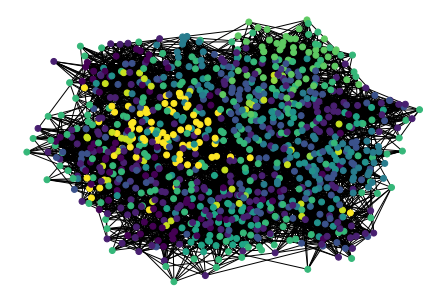

In [12]:
nx.draw(lfr, node_size=35, node_color=kmeans_lfr.labels_)

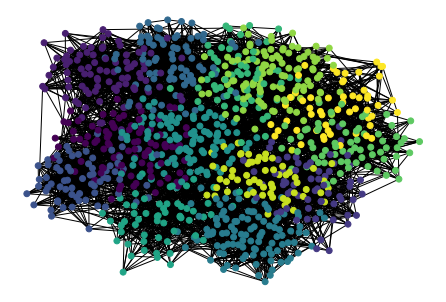

In [13]:
nx.draw(lfr, node_size=35, node_color=lfr_labels)

In [14]:
#read in football network data
url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.urlopen(url)  
s = io.BytesIO(sock.read())  
sock.close()

zf = zipfile.ZipFile(s) 
txt = zf.read("football.txt").decode() 
gml = zf.read("football.gml").decode()  
gml = gml.split("\n")[1:]
football = nx.parse_gml(gml)  

In [15]:
#115-64-32-16

X_football_1 = tf.convert_to_tensor(nx.modularity_matrix(football))

ae_football_1 = Autoencoder(115, 64)
ae_football_1.compile(optimizer='adam', loss="mse")
ae_football_1.fit(X_football_1, X_football_1, epochs=5000, shuffle=True, batch_size=115, verbose=0)

X_football_2 = ae_football_1.encoder(X_football_1)

ae_football_2 = Autoencoder(64, 32)
ae_football_2.compile(optimizer='adam', loss="mse")
ae_football_2.fit(X_football_2, X_football_2, epochs=5000, shuffle=True, batch_size=64, verbose=0)

X_football_3 = ae_football_2.encoder(X_football_2)

ae_football_3 = Autoencoder(32, 16)
ae_football_3.compile(optimizer='adam', loss="mse")
ae_football_3.fit(X_football_3, X_football_3, epochs=5000, shuffle=True, batch_size=32, verbose=0)

In [22]:
H_football = ae_football_3.encoder(X_football_3)
football_labels = [football.nodes[v]['value'] for v in football]
kmeans_football = KMeans(n_clusters=12, random_state=0).fit(H_football)

In [23]:
normalized_mutual_info_score(football_labels, kmeans_football.labels_)

0.8463344167127496

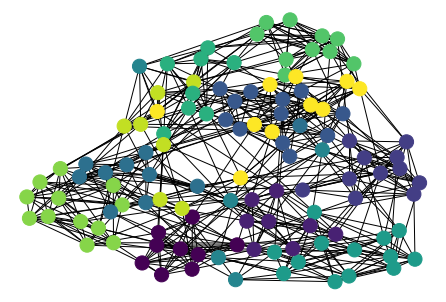

In [30]:
nx.draw(football, node_size=200, node_color=football_labels)

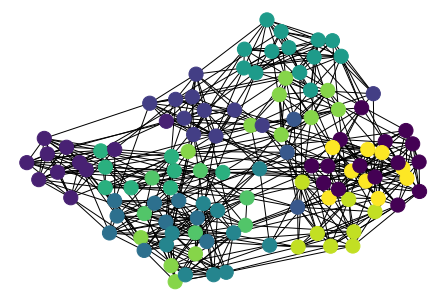

In [31]:
nx.draw(football, node_size=200, node_color=kmeans_football.labels_)

In [32]:
pickle.dump(football, open("football.p", "wb"))
ae_football_1.save("ae_football_1")
ae_football_2.save("ae_football_2")
ae_football_3.save("ae_football_3")

INFO:tensorflow:Assets written to: ae_football_1\assets
INFO:tensorflow:Assets written to: ae_football_2\assets
INFO:tensorflow:Assets written to: ae_football_3\assets
